# Setup

In [1]:
using DifferentialEquations, Plots, Turing, Interpolations, StatsPlots
using LightGraphs, MetaGraphs
using GraphRecipes

# Three node network

Adjacency matrix

In [2]:
num_nodes = 3

W = [0.0 0.2 0.0; 0.4 0.0 0.0; 0.0 0.3 0.0]

3×3 Array{Float64,2}:
 0.0  0.2  0.0
 0.4  0.0  0.0
 0.0  0.3  0.0

Plot the network

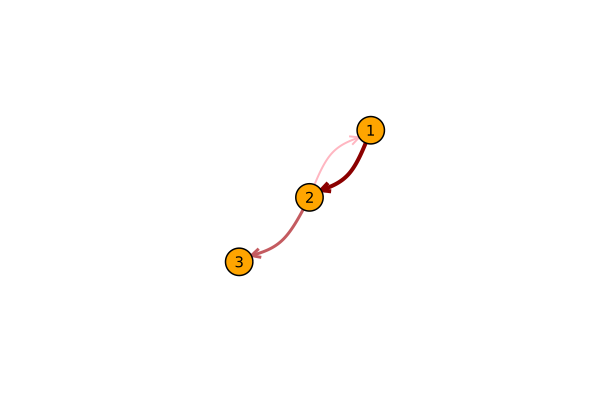

In [3]:
graph = SimpleDiGraph(3)
add_edge!(graph, 1,2)
add_edge!(graph, 2,1)
add_edge!(graph, 2,3)

metagraph = MetaDiGraph(graph)

set_prop!(metagraph, Edge(1,2), :weight, 4.0)
set_prop!(metagraph, Edge(2,1), :weight, 2.0)
set_prop!(metagraph, Edge(2,3), :weight, 3.0)

set_prop!(metagraph, 1, :name, "1")
set_prop!(metagraph, 2, :name, "2")
set_prop!(metagraph, 3, :name, "3")

graphplot(graph, nodesize=0.2, nodeshape=:circle,
    fontsize=10,
    edge_width=(s,d,w) -> get_prop(metagraph, Edge(s,d), :weight),
    line_z=reshape([4.; 2.; 3], 1, :),
    arrow=true,
    nodestrokewidth=1.5,
    nodecolor=:orange,
    edgecolor=:reds,
    curvature_scalar=0.1,
    names=[get_prop(metagraph,n,:name) for n in 1:size(metagraph)[1]],
    self_edge_size=1.0,
    axis_buffer=0.9
    )

Define sigmoid function

In [4]:
phi(a::Number) = (exp(2*a)-1)/(exp(2*a)+1)

phi (generic function with 1 method)

Define noise model

In [5]:
function additive_noise!(du,u,p,t)
    σ = p[length(p)] #make sure ϕ is the last value in the parameter array
    for i = 1:length(u)
        #This value multiplies a random number drawn from N(0, dt) i.e. noise then scales with sampling rate and effective sd of noise will be e.g. 0.1*dt
        du[i] = σ 
    end
end

additive_noise! (generic function with 1 method)

Define network propagation without stimulation

In [6]:
function no_input!(du,u,p,t)
    s,g,b,σ = p
    
    for i=1:length(u)
        du[i] = -u[i] + s*phi(u[i]) + g*(sum(W[i,:].*u))
    end
end

no_input! (generic function with 1 method)

Define network propagation **with** stimulation

In [7]:
function w_input!(du,u,p,t)
    s,g,b,σ = p
     
    for i=1:length(u)
        du[i] = -u[i] + s*phi(u[i]) + g*(sum(W[i,:].*u)) + b*I[i](t)
    end
end

w_input! (generic function with 1 method)

Define task structure for network that'll be stimulated

In [8]:
num_blocks = 4
on_len = 10
off_len = 10
stim = repeat([repeat([0.0], Int(off_len)); repeat([1.0], Int(on_len)); repeat([0.0], Int(off_len));], Int(num_blocks))
Tmax = length(stim)
nostim = repeat([0.0], Tmax)
ts = 1:1:Tmax
stim_node = 1
I = Array{Interpolations.FilledExtrapolation}(undef, 3)
for i=1:num_nodes
    if i==stim_node
        I[i] = LinearInterpolation(ts, stim, extrapolation_bc = 0)
    else
        I[i] = LinearInterpolation(ts, nostim, extrapolation_bc = 0)
    end
end

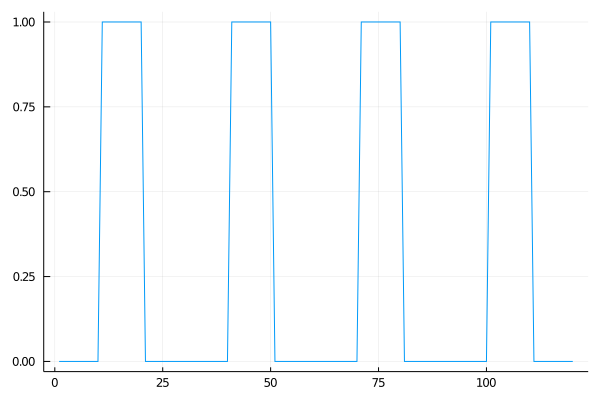

In [9]:
plot(stim, legend=false)

Define simulation parameters and SDE problems

In [17]:
u0 = repeat([0.0], num_nodes)
tspan = (0,Float64(Tmax))

dt = 0.25
# s,g,b,σ = p
p = [0.3, 0.7, 0.5, 0.01]

prob_noinput = SDEProblem(no_input!,additive_noise!,u0,tspan,p)
prob_winput = SDEProblem(w_input!,additive_noise!,u0,tspan,p)
# sol = solve(prob_sde, dt=dt, adaptive=false)
# plot(sol)

SDEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 120.0)
u0: [0.0, 0.0, 0.0]

Note: If you don't turn off adaptive step size for `solve` function then the number of solved points will not be Tmax/dt. It will be determined as detailed [here](https://diffeq.sciml.ai/stable/basics/common_solver_opts/#Basic-Stepsize-Control).

Generate 25 networks with 3 nodes and solve the SDE for each of them.

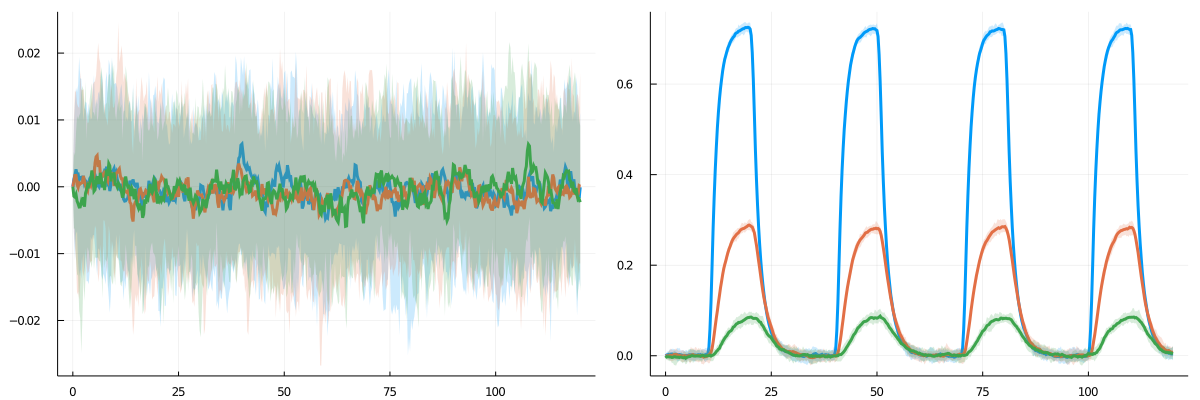

In [18]:
ens_noinput = EnsembleProblem(prob_noinput)
dat_noinput = solve(ens_noinput, SOSRI(), trajectories=25, dt=dt, adaptive=false)
ens_winput = EnsembleProblem(prob_winput)
dat_winput = solve(ens_winput, SOSRI(), trajectories=25, dt=dt, adaptive=false)
p1 = plot(EnsembleSummary(dat_noinput))
p2 = plot(EnsembleSummary(dat_winput))
plot(p1, p2, layout=(1,2), size=(1200, 400))

In [19]:
Turing.setadbackend(:forwarddiff)

:forwarddiff

In [20]:
@model function fit_noinput(data, prob)
    s ~ truncated(Normal(1.0,1.0),0.0,3.0)
    g ~ truncated(Normal(1.0,1.0),0.0,3.0)
    b = 0.0
    σ ~ truncated(Normal(0.0,1.0),-3.0,3.0)
    obs_noise ~ InverseGamma(2,3)
    
    p = [s,g,b,σ]

    prob = remake(prob, p=p)
    predicted = solve(prob, SOSRI(), dt=dt, adaptive=false)

    if predicted.retcode != :Success
        Turing.acclogp!(_varinfo, -Inf)
    end
    for j in 1:length(data) #number of ensemble iterations
        for i = 1:length(predicted) #number of time points
            data[j][i] ~ MvNormal(predicted[i], obs_noise) #generate 3 points at a time for each node
        end
    end
end;

┌ Warning: you are using the internal variable `_varinfo`
└ @ DynamicPPL /Users/zeynepenkavi/.julia/packages/DynamicPPL/wf0dU/src/compiler.jl:171


In [30]:
@model function fit_winput(data, prob)
    s ~ truncated(Normal(1.0,1.0),0.0,3.0)
    g ~ truncated(Normal(1.0,1.0),0.0,3.0)
    b ~ truncated(Normal(1.0,1.0),-3.0,3.0)
    σ ~ truncated(Normal(0.0,1.0),-3.0,3.0)
    obs_noise ~ InverseGamma(2,3)
    
    p = [s,g,b,σ]

    prob = remake(prob, p=p)
    predicted = solve(prob, SOSRI(), dt=dt, adaptive=false)

    if predicted.retcode != :Success
        Turing.acclogp!(_varinfo, -Inf)
    end
    for j in 1:length(data) #number of ensemble iterations
        for i = 1:length(predicted) #number of time points
            data[j][i] ~ MvNormal(predicted[i], obs_noise) #generate 3 points at a time for each node
        end
    end
end;

┌ Warning: you are using the internal variable `_varinfo`
└ @ DynamicPPL /Users/zeynepenkavi/.julia/packages/DynamicPPL/wf0dU/src/compiler.jl:171


In [31]:
mod_noinput = fit_noinput(dat_noinput, prob_noinput)
mod_winput = fit_winput(dat_winput, prob_winput)

DynamicPPL.Model{var"#9#10",(:data, :prob),(),(),Tuple{EnsembleSolution{Float64,3,Array{RODESolution{Float64,2,Array{Array{Float64,1},1},Nothing,Nothing,Array{Float64,1},NoiseProcess{Float64,2,Float64,Array{Float64,1},Array{Float64,1},Array{Array{Float64,1},1},typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_DIST),typeof(DiffEqNoiseProcess.INPLACE_WHITE_NOISE_BRIDGE),true,ResettableStacks.ResettableStack{Tuple{Float64,Array{Float64,1},Array{Float64,1}},true},ResettableStacks.ResettableStack{Tuple{Float64,Array{Float64,1},Array{Float64,1}},true},RSWM{Float64},Nothing,RandomNumbers.Xorshifts.Xoroshiro128Plus},SDEProblem{Array{Float64,1},Tuple{Float64,Float64},true,Array{Float64,1},Nothing,SDEFunction{true,typeof(w_input!),typeof(additive_noise!),LinearAlgebra.UniformScaling{Bool},Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing,Nothing},typeof(additive_noise!),Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Nothing},SOSRI,S

In [24]:
@time q_noinput = vi(mod_noinput, ADVI(10, 2000))

┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 9203665098626605002
└ @ AdvancedVI /Users/zeynepenkavi/.julia/packages/AdvancedVI/8ttTK/src/AdvancedVI.jl:199
[ADVI] Optimizing...100% Time: 0:11:27


710.071813 seconds (7.28 G allocations: 460.589 GiB, 12.52% gc time)


Bijectors.TransformedDistribution{DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}},Stacked{Tuple{Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Bijectors.Exp{0}},4},Multivariate}(
dist: DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}}(m=[-9.437924669385358, -4.740413536434671, -0.00014142963058994947, -4.46906252480069], σ=[0.5583494855552481, 0.6879417600809947, 0.00016663702528165462, 0.006666504101671167])
transform: Stacked{Tuple{Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Bijectors.Exp{0}},4}((Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0}(Bijectors.TruncatedBijector{0,Float64,Float64}(0.0, 3.0)), Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0}(Bijectors.TruncatedBij

In [32]:
@time q_winput = vi(mod_winput, ADVI(10, 2000))

┌ Info: [ADVI] Should only be seen once: optimizer created for θ
│   objectid(θ) = 8731336031097490647
└ @ AdvancedVI /Users/zeynepenkavi/.julia/packages/AdvancedVI/8ttTK/src/AdvancedVI.jl:199
[ADVI] Optimizing...100% Time: 0:12:01


722.343195 seconds (8.04 G allocations: 524.712 GiB, 14.53% gc time)


Bijectors.TransformedDistribution{DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}},Stacked{Tuple{Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Bijectors.Exp{0}},5},Multivariate}(
dist: DistributionsAD.TuringDiagMvNormal{Array{Float64,1},Array{Float64,1}}(
m: [-2.240831269026955, -1.1633677107663887, 0.3399881436076624, -1.0389981660388331e-5, -4.242252065608392]
σ: [0.0026865395330805952, 0.0008909611345346008, 0.00030282375540710435, 0.00015211221101017394, 0.012272563168148964]
)

transform: Stacked{Tuple{Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Inverse{Bijectors.TruncatedBijector{0,Float64,Float64},0},Bijectors.Exp{0}},5}((Inverse{Bijectors.Truncate

In [34]:
samp_noinput = rand(q_noinput, 10000)

4×10000 Array{Float64,2}:
  0.000150751   0.000307418   0.000262011  …   0.000173072   0.000105011
  0.00662969    0.18774       0.0179991        0.0485626     0.0186992
 -0.000582946  -0.000475547  -0.000289356     -0.000468267  -0.000168435
  0.011392      0.0115298     0.0114101        0.0114579     0.0114935

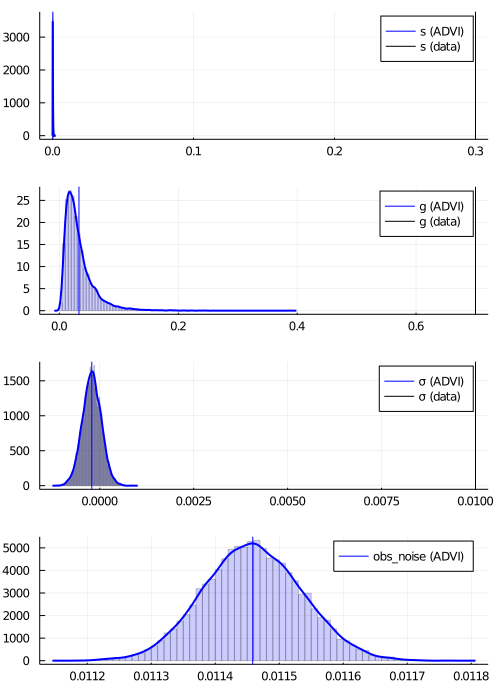

In [38]:
#The vector has the same ordering as the model
# s, g, σ, obs_noise
p1 = histogram(samp_noinput[1, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samp_noinput[1, :], label = "s (ADVI)", color = :blue, linewidth = 2)
vline!([p[1]], label = "s (data)", color = :black)
vline!([mean(samp_noinput[1, :])], color = :blue, label ="")

p2 = histogram(samp_noinput[2, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samp_noinput[2, :], label = "g (ADVI)", color = :blue, linewidth = 2)
vline!([p[2]], label = "g (data)", color = :black)
vline!([mean(samp_noinput[2, :])], color = :blue, label ="")

p3 = histogram(samp_noinput[3, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samp_noinput[3, :], label = "σ (ADVI)", color = :blue, linewidth = 2)
vline!([p[4]], label = "σ (data)", color = :black)
vline!([mean(samp_noinput[3, :])], color = :blue, label ="")

p4 = histogram(samp_noinput[4, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samp_noinput[4, :], label = "obs_noise (ADVI)", color = :blue, linewidth = 2)
vline!([mean(samp_noinput[4, :])], color = :blue, label ="")

plot(p1, p2, p3, p4, layout=(4,1), size=(500, 700))

In [40]:
samp_winput = rand(q_winput, 10000)

5×10000 Array{Float64,2}:
  0.288213      0.28719     0.288739    …   0.28767      0.289393
  0.714232      0.714481    0.714959        0.713703     0.713117
  0.504774      0.504789    0.504833        0.504773     0.50565
 -0.000280644  -9.35226e-5  0.00016343     -0.000255168  0.000207127
  0.0143608     0.0144582   0.0144639       0.0143703    0.0140067

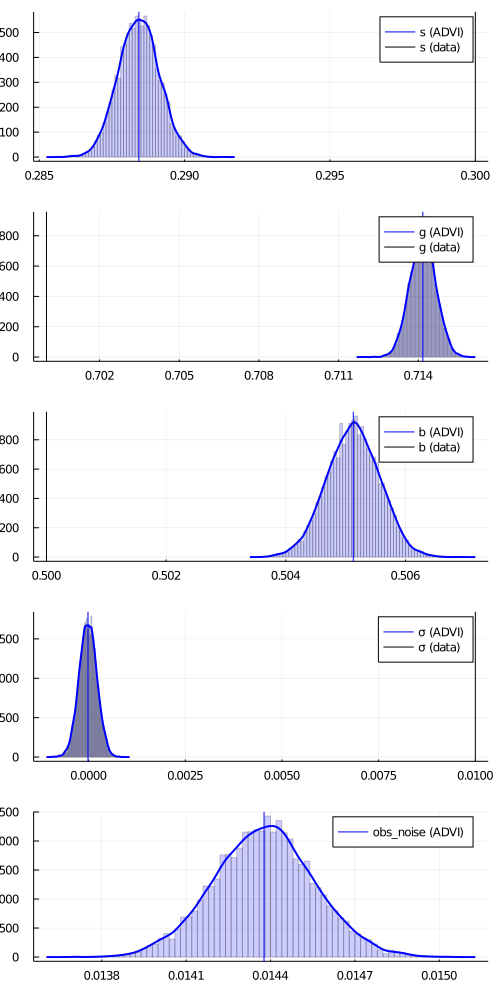

In [41]:
#The vector has the same ordering as the model
# s, g, b, σ, obs_noise
p1 = histogram(samp_winput[1, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samp_winput[1, :], label = "s (ADVI)", color = :blue, linewidth = 2)
vline!([p[1]], label = "s (data)", color = :black)
vline!([mean(samp_winput[1, :])], color = :blue, label ="")

p2 = histogram(samp_winput[2, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samp_winput[2, :], label = "g (ADVI)", color = :blue, linewidth = 2)
vline!([p[2]], label = "g (data)", color = :black)
vline!([mean(samp_winput[2, :])], color = :blue, label ="")

p3 = histogram(samp_winput[3, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samp_winput[3, :], label = "b (ADVI)", color = :blue, linewidth = 2)
vline!([p[3]], label = "b (data)", color = :black)
vline!([mean(samp_winput[3, :])], color = :blue, label ="")

p4 = histogram(samp_winput[4, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samp_winput[4, :], label = "σ (ADVI)", color = :blue, linewidth = 2)
vline!([p[4]], label = "σ (data)", color = :black)
vline!([mean(samp_winput[4, :])], color = :blue, label ="")

p5 = histogram(samp_winput[5, :], bins=100, normed=true, alpha=0.2, color = :blue, label = "")
density!(samp_winput[5, :], label = "obs_noise (ADVI)", color = :blue, linewidth = 2)
vline!([mean(samp_winput[5, :])], color = :blue, label ="")

plot(p1, p2, p3, p4, p5, layout=(5,1), size=(500, 1000))

Correlation between parameters?

Likelihood surface?

What is b estimated if you just regress the timeseries on the task vector?

b's should be different for each node!

In [ ]:
# @time chain = sample(model, NUTS(), 500)
# plot(chain)
